
# Image Segmentation from membrane images

Cell segmentation from images showing membranes can be challenging, e.g. as some markers do not mark membranes continously. Thus, some pre-processing needs to be done in order to retrieve optimal segmentation results.

To demonstrate the workflow, we're using single slices derived from 3D image data from the Broad Bio Image Challenge, _Thirstrup et al. 2018, available from the Broad Bioimage Benchmark Collection, Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637_ (__doi. PMID:__ 22743765 __PMCID:__ PMC3627348). Available at http://dx.doi.org/10.1038/nmeth.2083

We start by opening an example image and configuring an intersting sub-region.


In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

import pyclesperanto as cle

cle.select_device()

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.216.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Maximum Object Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

We start by loading the image to the device memory, and run a first segmentation using basic thresholding to see how good it can be done right away.

array([[447, 430, 461, ..., 373, 383, 345],
       [394, 403, 379, ..., 381, 362, 417],
       [393, 459, 400, ..., 388, 409, 360],
       ...,
       [471, 463, 454, ..., 543, 596, 619],
       [510, 511, 463, ..., 624, 626, 551],
       [495, 455, 483, ..., 573, 579, 626]], dtype=uint16, mtype=buffer)
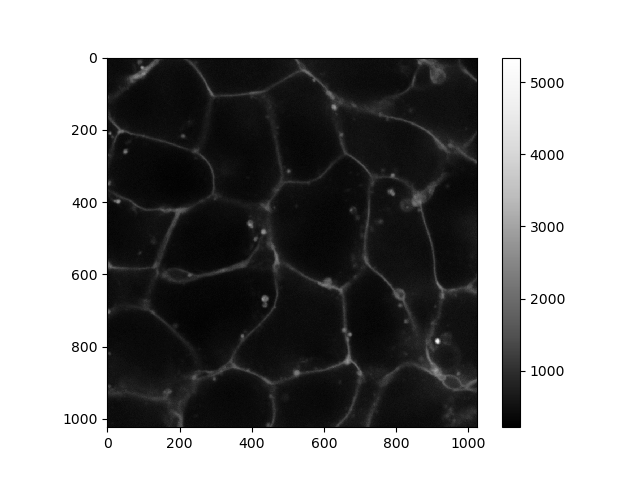
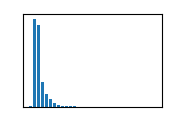

In [4]:
input_image = cle.push(imread("../data/BBBC034_v1_dataset/AICS_12_134_C=0.tif"))
input_image

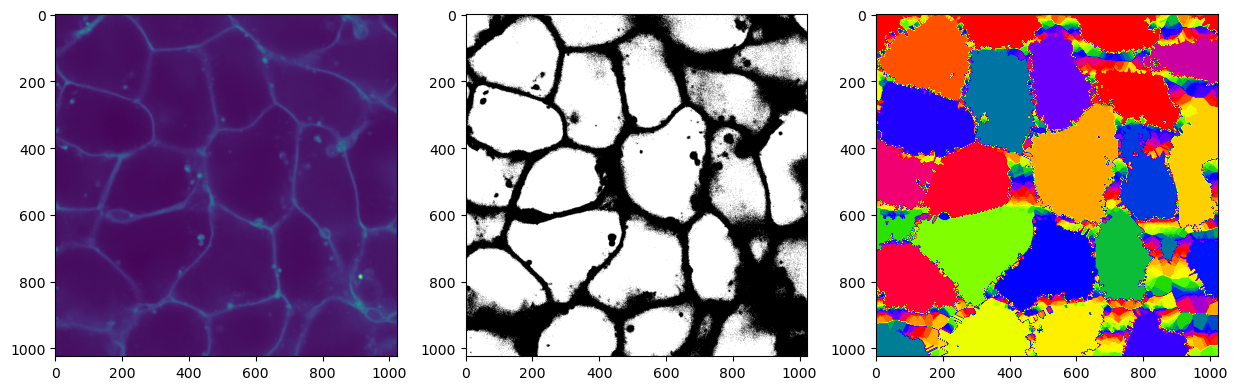

In [5]:
threshold = 550
binary = input_image < threshold
labels = cle.voronoi_labeling(binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(input_image)
axs[1].imshow(binary, cmap='gray')
axs[2].imshow(labels, cmap='prism')
plt.show()

Alternatively, with some intermediate correction, e.g. binary opening, we can improve segmentation quality in the binary image before labeling individual objects.

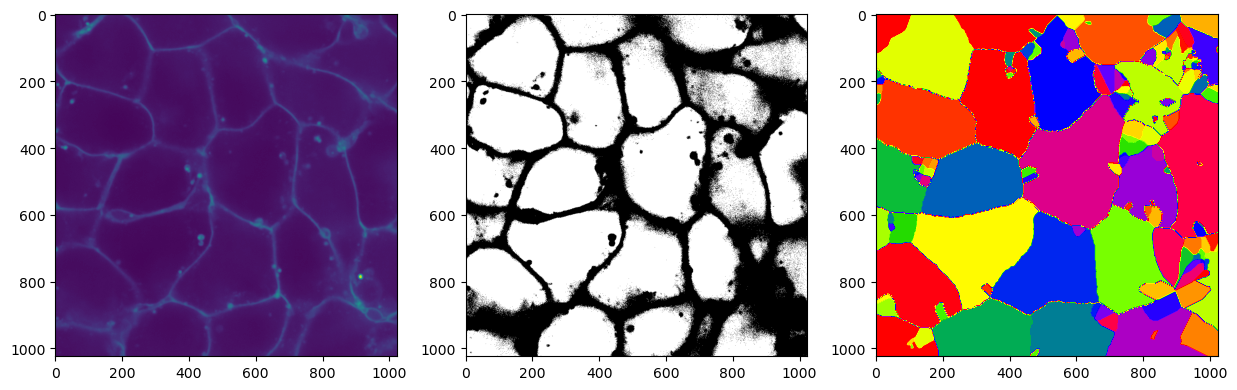

In [6]:
binary = input_image < threshold
# binary opening
corrected_binary = cle.binary_opening(binary, radius_x=2, radius_y=2)
labels = cle.voronoi_labeling(corrected_binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(input_image)
axs[1].imshow(binary, cmap='gray')
axs[2].imshow(labels, cmap='prism')
plt.show()

Alternatively, we can improve segmentation quality by making the membranes virtualy thicker in the original image before thresholding:

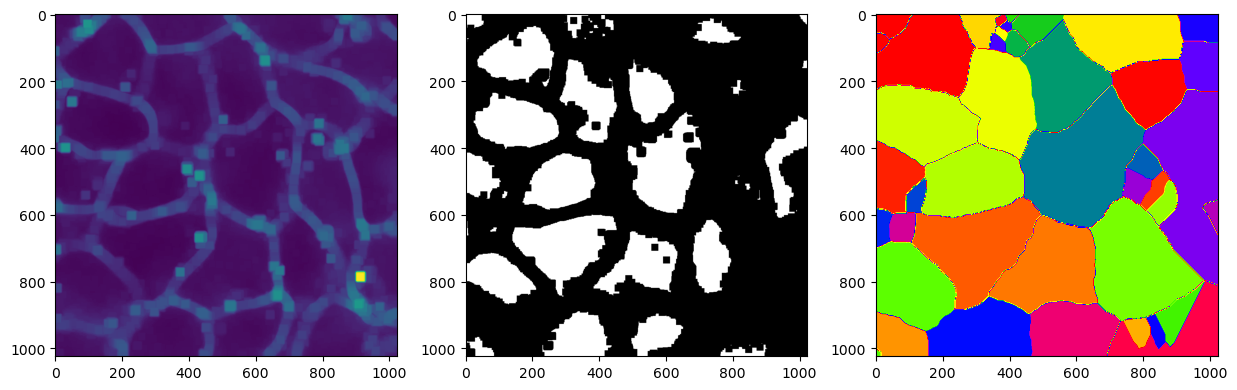

In [7]:
# greyscale dilation, a.k.a. a maximum-filter
thicker_membranes = cle.grayscale_dilate(input_image, radius_x=10, radius_y=10)
binary = thicker_membranes < threshold
labels = cle.voronoi_labeling(binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(thicker_membranes)
axs[1].imshow(binary, cmap='gray')
axs[2].imshow(labels, cmap='prism')
plt.show()

Finally, it is possible to filter labels on their size, e.g. removing small label which do not correspond to any valid segmentation

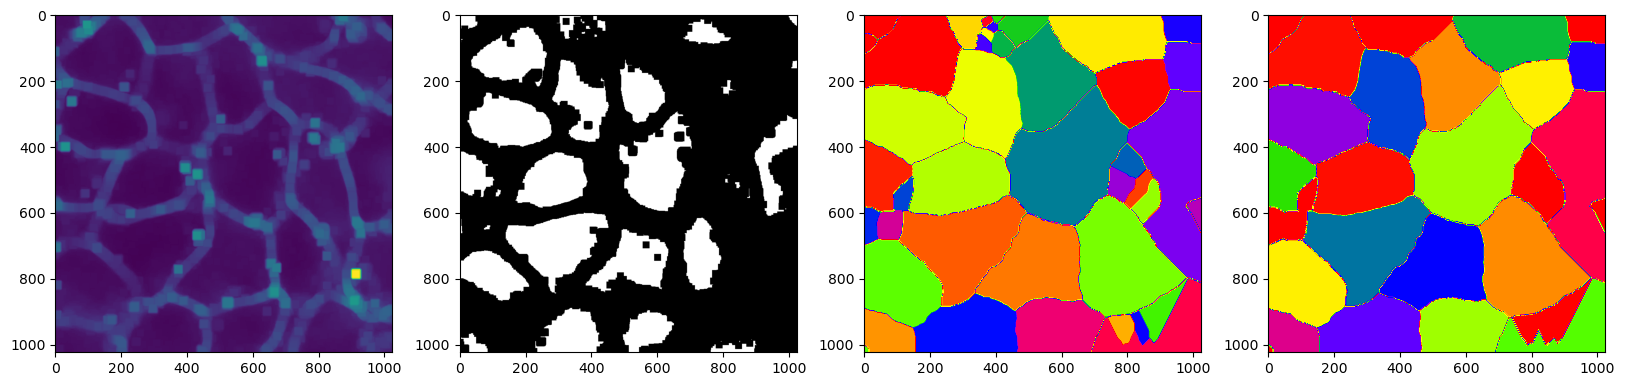

In [8]:
filtered_labels = cle.remove_small_labels(labels, minimum_size=10000)

fig, axs = plt.subplots(1, 4, figsize=(20, 15))
axs[0].imshow(thicker_membranes)
axs[1].imshow(binary, cmap='gray')
axs[2].imshow(labels, cmap='prism')
axs[3].imshow(filtered_labels, cmap='prism')
plt.show()